***Case study discription***

In this case study, a dataset of 7,500 companies that includes the company name and a text description of its activity is investigated. A training set of 5,000 companies is provided with their respective categorization labels. A testing set of 2,500 companies is provided without their labels.
The objective is to to predict the categorization labels of the 2,500 companies in the test set using machine learning techniques. 

In [2]:
#math
import pandas as pd
import numpy as np
#visualization
import matplotlib.pyplot as plt
#preproc
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
#ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
#importing dataset
data = pd.read_csv('data_train.csv')
data_test = pd.read_csv('data_eval.csv')

## Data Exploration

In [9]:
data.head()

,id,name,description,industry
0,1799,Quikr,Quikr is a free classifieds and online marketp...,PropTech
1,613,CommonFloor.com,CommonFloor is a leading real estate platform ...,PropTech
2,2321,Home24,"Home24 SE markets, sells, and ships furniture ...",PropTech
3,3300,Loft,Loft develops a real-estate platform intended ...,PropTech
4,4005,Opendoor,Opendoor makes it possible to receive an offer...,PropTech


In [7]:
data.description[0]

'Quikr is a free classifieds and online marketplace that helps users to sell, buy, rent, or discover anything across India. Community members can come to their site to find an apartment to live in, sell their old car, bike ,music system, laptop or furniture, promote their small business, find a tuition class or get a break as a model or actor, join a salsa class, get an audience for a local event, buy any item that they might want or have to offer and make new friends while doing all of the above. Their aim is to empower every person in the country to independently connect with buyers and sellers online. Their idea is to consistently keep adding something game-changing and worthwhile to your Quikr experience - whether it is QuikrNXT, the freedom to buy or sell without risking your privacy, or the missed call service, to give Quikr access to the masses who aren’t online today but would have internet access in the near future.'

In [11]:
data_test.head()

,id,name,description
0,6593,Apex Infosys India,Apex Infosys is a leading provider of automati...
1,7219,Babcock Ntuthuko Engineering,Babcock Ntuthuko Engineering is a line of busi...
2,5506,BMI Group,BMI Group is part of the Standard Industries f...
3,7251,Cellectar Biosciences,"Cellectar Biosciences, a radiopharmaceutical c..."
4,6215,ConnectPoint,ConnectPoint is an IT Solutions Provider and D...


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5000 non-null   int64 
 1   name         5000 non-null   object
 2   description  5000 non-null   object
 3   industry     5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [13]:
data.shape

(5000, 4)

In [14]:
data_test.shape

(2500, 3)

In [15]:
data.isnull().sum()

id             0
name           0
description    0
industry       0
dtype: int64

Checking the balance of the industry classes

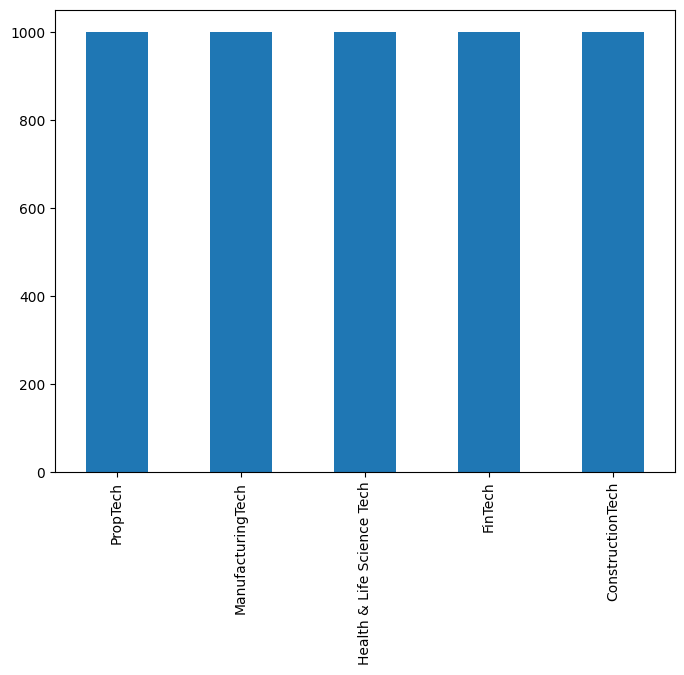

In [16]:
fig = plt.figure(figsize=(8,6))
data['industry'].value_counts().plot(kind='bar', ylim=0)
plt.show()

## Data Preprocessing

In [17]:
#extracting raw training feature and target
X = data['description']
y = data['industry']

**Data cleaning:** Building a function to clean the description text

In [18]:
def clean(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') 
    lowercased = text.lower() 
    tokenized = word_tokenize(lowercased) 
    words_only = [word for word in tokenized if word.isalpha()] 
    stop_words = set(stopwords.words('english')) 
    without_stopwords = [word for word in words_only if not word in stop_words] 
    lemma=WordNetLemmatizer() 
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] 
    cleaned = ' '.join(lemmatized) 
    return cleaned

In [19]:
X_clean = X.apply(clean)

Example of cleaned description text

In [20]:
X_clean[0]

'quikr free classified online marketplace help user sell buy rent discover anything across india community member come site find apartment live sell old car bike music system laptop furniture promote small business find tuition class get break model actor join salsa class get audience local event buy item might want offer make new friend aim empower every person country independently connect buyer seller online idea consistently keep adding something game changing worthwhile quikr experience whether quikrnxt freedom buy sell without risking privacy missed call service give quikr access mass online today would internet access near future'

**Text representation:** Vectorizing the clean text using TF-IDF text representation. I chose this method instead of bag of words to consider both the frequency and the importance of the words.

In [21]:
vectorizer_tfidf = TfidfVectorizer(max_features=10000)
X_tfidf_vectorized = vectorizer_tfidf.fit_transform(X_clean)

**Target encoding:** using label encoder for multi class target

In [22]:
encoder = LabelEncoder()
encoder.fit(y) 
y_encoded = encoder.transform(y)

In [23]:
np.unique(y_encoded)

array([0, 1, 2, 3, 4])

## Base Score Benchmark

In [24]:
#choosing the base score to be the probability of selecting a random class from a balanced dataset
base_score_benchmark = 1/len(y.unique())
base_score_benchmark

0.2

## Modelling

**Modelling strategy:** Starting with a simple and fast model (Naive Bayes classifier) for its simplicity and computational efficiency. I will then proceed to explore Logistic Regression and two more complex models (SVM and Random Forest)

**Scoring**: choosing F1 Macro scoring to consider both precision and recall while giving equal importance to all classes

### Model I: Naive Bayes model

In [25]:
nb_model = MultinomialNB()

In [26]:
#cross validating
nb_model_results = cross_validate(nb_model, X_tfidf_vectorized, y_encoded,cv=5, scoring='f1_macro')
nb_model_results['test_score'].mean()

0.8433128655566605

### Model II: Logistic Regressor

In [27]:
lg_model = LogisticRegression(max_iter=1000)

In [28]:
#cross validating
lg_model_results = cross_validate(lg_model, X_tfidf_vectorized, y_encoded, cv=5, scoring='f1_macro')
lg_model_results['test_score'].mean()

0.8642291807592958

### Model III: Support Vector Model

In [29]:
svm_model = SVC()

In [30]:
svm_model_results = cross_validate(svm_model, X_tfidf_vectorized, y_encoded, cv=5, scoring='f1_macro')
svm_model_results['test_score'].mean()

0.8639224079648196

### Model IV: Random Forest Classifier

In [31]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=50)

In [32]:
#cross validating
rf_model_results = cross_validate(rf_model, X_tfidf_vectorized, y_encoded, cv=5, scoring='f1_macro')
rf_model_results['test_score'].mean()

0.8386757180299611

## Optimization

The models had scores between 0.84-0.86 with logestic regressor being the highest. I will fine tune the logestic regression model and use the optimized version for the final prediction.

**Optimization strategy:** I will attempt to optimize the number of features and the model hyper paramters in parallel to find the optimum combination. For the hyper paramters, I will adjust the regularization strength while trying different solvers.

In [33]:
lg_pipeline = Pipeline([('verctorizer', TfidfVectorizer()), ('model', LogisticRegression(max_iter=1000))])

In [34]:
#lg_pipeline.get_params()

In [35]:
lg_pipeline_grid={'verctorizer__max_features': range(500,20000,500),
                 'model__C':[0.25, 0.5, 0.75, 1, 1.5, 3, 4.5,13,20],
                 'model__solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
lg_pipeline_search = GridSearchCV(lg_pipeline, lg_pipeline_grid, cv=5, scoring= 'f1_macro', n_jobs=-1)
lg_pipeline_search.fit(X_clean, y_encoded)
lg_pipeline_search.best_score_, lg_pipeline_search.best_params_

(0.8688632863772332,
 {'model__C': 1, 'model__solver': 'lbfgs', 'verctorizer__max_features': 3000})

In [36]:
lg_pipeline_opt = lg_pipeline_search.best_estimator_

## Prediction

Preprocessing test dataset

In [37]:
X_test_clean = data_test['description'].apply(clean)

In [38]:
X_test_clean[0]

'apex infosys leading provider automation networking system home business offering personalized unified smart home system automate control connected device including lighting audio video climate control intercom security founded advait thakur apex infosys currently focused making everyone life simple secure offering unprecedented visibility control entire house apex infosys india product service partnership deliver smarter home access ensuring energy greener smarter cheaper apex also involved artificial intelligence healthcare sector'

In [39]:
X_test_clean.shape

(2500,)

Training the optimized pipeline

In [40]:
lg_pipeline_opt.fit(X_clean, y_encoded)

Pipeline(steps=[('verctorizer', TfidfVectorizer(max_features=3000)),
                ('model', LogisticRegression(C=1, max_iter=1000))])

Predicting the target labels

In [41]:
y_predict_encoded = lg_pipeline_opt.predict(X_test_clean)
y_predict_text = encoder.inverse_transform(y_predict_encoded)

In [42]:
y_predict_text.shape

(2500,)

combining the target labels with the ids column

In [43]:
result = pd.DataFrame(data_test['id'])
result['Label'] = y_predict_text

In [44]:
result.head()

,id,Label
0,6593,PropTech
1,7219,ConstructionTech
2,5506,ConstructionTech
3,7251,Health & Life Science Tech
4,6215,ManufacturingTech


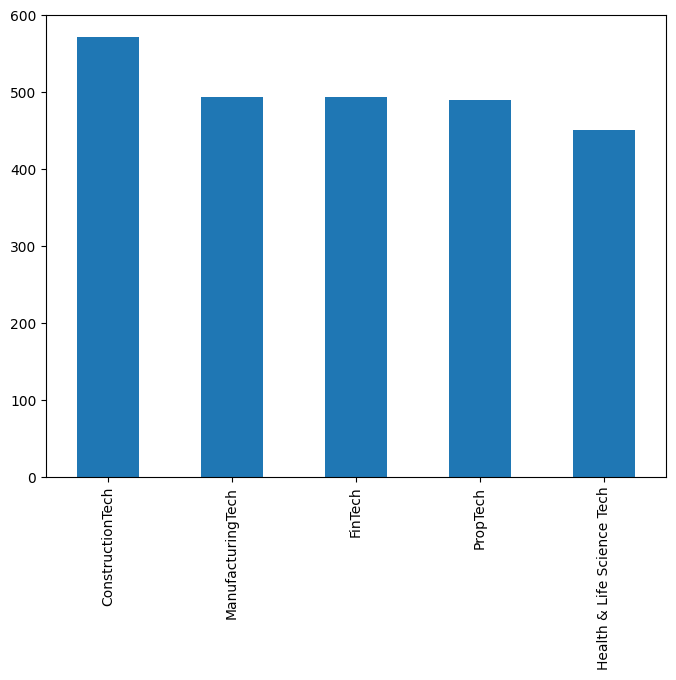

In [48]:
fig = plt.figure(figsize=(8,6))
result['Label'].value_counts().plot(kind='bar', ylim=0)
plt.show()

In [50]:
result.to_csv('NLP_Case_Study_MoatazAbdelmegid.csv', index=False)